# MNIST classification

오늘부터 pytorch로 딥러닝을 다시 시작해보려 한다.
요새 코딩을 통 하지 않아 까먹기도 했고, 처음부터 착착착 쌓아가고 싶은 마음도 있었다.
나만의 스크래치 코딩을 통해..

계획은 이렇다.

```
1. classification > MNIST > CNN, RNN, LSTM, transformer
2. classification > IMDB > LSTM, transformer
3. classification > CIFAR-10 > CNN, RNN, LSTM, transformer
4. generation > text data > seq2seq, transformer, BERT
5. 그 외.. (grad-CAM, GAN, time-series, anomaly-d, reinforcement ..)
```


이렇게 다양한 task에 대해 착착 쌓아가고 싶다.

바쁜 스케줄 속에서, 꾸준히 이걸 해나가려면, 아마 잠자는 시간을 쪼개야 할 것이다.
잠자는 건.. 주말에 하루 몰아서 푹 자자.

숲 속에 있다보니, 멍 때리면서 가끔 지금의 시간이 얼마나 소중한지를 잊곤 한다.
잊지 말자. 그 기억, 그 깨달음이 너의 힘인 데, 그걸 잊으면 넌 모두 잃어버리는 것이나 마찬가지다.

여튼, 오늘부터 MNIST 데이터 셋을 받아, digit image classificaiton task를 풀어볼 것이다.

## module import

필요한 module들을 꺼내올 것이다. 보통 library > package > module 포함관계로 생각하면 된다. module이 '.py' 로 구성되는 script파일을 생각하면 되고, 이를 모아놓은 것을 하나의 package로 생각할 수 있다. 

따라서, package는 주로 하나의 directory를 이루는 경우가 많다. 물론, package안에 .py 파일만 있는 것이 아니라, 폴더도 존재할 수 있다. 이렇게 package(folder) > subpackage(folder) > module(.py file) 식 구성도 가능하다.

일단, 먼저 가장 기본적인 pytorch 라이브러리인 ```torch```관련 모듈을 import 한다.
(numpy 등 기본적인 라이브러리는 개인 설정을 통해 쥬피터노트북 시작과 함께 미리 모두 import 되도록 해놓아서, 따로 import하지는 않았다. 그 외 실험에 필요한 라이브러리, 패키지들은 실험 중간중간 필요할 때마다 import 할 예정이다.)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


## Data Preparation (MNIST)

이젠 MNIST dataset을 download 할 것이다. MNIST dataset은 워낙 유명하고, 여러 예제로 많이 쓰이는 데이터이기에 이미 torch, tensorflow, scikit-learn 등 다양한 라이브러리에 이미 내장되어 있다. 따라서, 해당 라이브러리에서 다운받을 수 있다. 이번엔 torch에서 다운로드 받을 것이다.

```
https://pytorch.org/vision/stable/datasets.html#
```

를 통해 torch에서 제공하는 dataset을 확인할 수 있다.

**torch dataset의 특징**

1. custom dataset 구성이 가능한 ```torch.utils.data.Dataset```를 상속
    - ```torchvision.datasets``` subclass에 dataset이 저장되어 있음
        - ex) ```imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')```
    - 이렇게 torchvision에서 다운 받은 dataset을 DataLoader의 batchify 대상이 되는 CustomDataset 정의!
    - CustomDataset정의 시, method overriding -> DataLoader에서의 Indexing(```__getitem__```), 전체 데이터 길이 확인(```__len__```)을 지정
        - ```__getitem__```
        - ```__len__```


설명에 따르면, torch의 모든 dataset(torchvision.datasets의 subclass로 구현된)은 ```torch.utils.data.Dataset```의 subclass이다. 즉, ```torch.utils.data.Dataset```를 상속받아 dataset을 구성한다는 것이다. 그리고, Dataset class는 ```__getitem__```, ```__len__``` method를 갖기 때문에, 이를 상속받을 땐, 2가지 method를 overriding 해줘야 한다.


2. 병렬 연산 batchify를 위한 ```torch.utils.data.DataLoader``` 활용 가능
    - DataLoader can load multiple samples in parallel using ```torch.multiprocessing```workers
    - 따라서, Dataset을 상속받아 __getitem__, __len__을 customizing 하고 -> 이를 활용해 DataLoader를 만들어, multi-processing이 가능하게끔 처리해준다. 그리고 이 DataLoader에서 batch단위로 데이터를 꺼내 학습시킨다! 
    
    
**정리하자면**
1. downloaded data
2. preprocessing (min-max scaling / flatten(when the structure of model is only fully-connected layer))
2. CustomDataset(downloaded data)
3. DataLoader(CustomDataset)

순으로 data -> batchify까지 마무리한다.



### downloaded data

In [2]:
import torchvision
from torchvision import transforms

In [3]:
mnist_train = torchvision.datasets.MNIST('./data/MNIST', 
                                        train=True,
                                        download=True,
                                        transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

torchvision을 통해 데이터를 다운받으려 했으나, HTTPError가 나왔다. 

```
http://yann.lecun.com/exdb/mnist/
```

공식 mnist 홈페이지 자체가 '503 service unavailable'이라 뜨는 것으로 보아, 내 환경의 문제가 아닌 듯 하다.
일단, 예전에 실습하며 받아놓았던 mnist data파일을 활용하기로 하자. 어떤 문제 앞에서도 유연하게...

In [5]:
# datasets.get_data_home()

In [6]:
# !ls -al /Users/kimjeongseob/scikit_learn_data/mldata

엇.. scikit-learn을 활용해 데이터를 로드할 수 있는 다른 방법을 알아보던 중.. 신기하게도

```
http://yann.lecun.com/exdb/mnist/
```

이 페이지가 다시 되살아났다.. 덕분에 torchvision을 통해 데이터 로드가 가능해졌다. 모두 다 저 페이지를 통해 다운받아서 load하도록 되어있기 때문에, 저 페이지가 죽으면 load할 수 없는 것이다..

In [7]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
print(dir(mnist_train))

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_format_transform_repr', '_is_protocol', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']


torchvision에서 받은 mnist_data_pack은 위와 같은 magic method와 attribute들로 구성되어 있다. 하나씩 살펴보자

In [9]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [10]:
mnist_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

일단 데이터 자체는 torch tensor로 구성되어있고, dtype은 uint8이다. uint8은 integer의 가장 기본적인 단위로 보면 된다. integer는 8, 16, 32, 64로 이어지는 데, 64일 경우, Long tensor라 부른다. uint8은 8bit=1byte로, byte-tensor라고도 한다. 즉, 현재의 mnist dataset은 1바이트씩 정보를 담고 있다는 의미가 되겠다.

In [11]:
mnist_train.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [12]:
mnist_train.targets.shape

torch.Size([60000])

In [13]:
x_train, y_train = mnist_train.data, mnist_train.targets

print(f"train x : {x_train.shape}, train y : {y_train.shape}")

train x : torch.Size([60000, 28, 28]), train y : torch.Size([60000])


train dataset은 총 6만개의 sample을 갖고 있고, 각 sample은 28x28로 되어있다. channel은 1개. 즉, gray-scale이고, 28x28 pixel을 갖고 있어, 해상도는 그리 좋지 않을 것 같다. 직접 데이터를 확인해보자

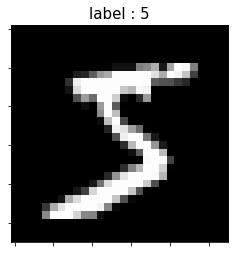

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot()
ax.tick_params(labelleft=False, labelbottom=False)
ax.grid(False)    
ax.imshow(x_train[0], cmap='gray')
ax.set_title(f"label : {y_train[0]}", fontsize=15)
plt.show()

위와 같이, 숫자 5가 이미지로 저장이 되어있다.

이제, 아래와 같은 단계를 거칠 예정이다.
```
1) test_set 다운로드
2) train_set 전처리 / shuffling
3) train / valid set split
4) Custom Dataset
5) DataLoader 구성 => train_loader, valid_loader, test_loader 구성
```

In [15]:
# 1) test_set download

mnist_test = torchvision.datasets.MNIST('./data/MNIST', 
                                        train=False, 
                                        download=True,
                                        transform=transforms.Compose([transforms.ToTensor()]))
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/MNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [16]:
mnist_test.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [17]:
x_test, y_test = mnist_test.data, mnist_test.targets

print(f"train x : {x_test.shape}, train y : {y_test.shape}")

train x : torch.Size([10000, 28, 28]), train y : torch.Size([10000])


In [18]:
# 2) train_set 전처리 / shuffling

# shuffling
indices = torch.randperm(x_train.shape[0])
print(f"indices shape : {indices.shape}")

x_train = torch.index_select(x_train, index=indices, dim=0)
y_train = torch.index_select(y_train, index=indices, dim=0)
print(f"x shape : {x_train.shape}, y shape : {y_train.shape}")

indices shape : torch.Size([60000])
x shape : torch.Size([60000, 28, 28]), y shape : torch.Size([60000])


In [19]:
# 전처리 => min-max scaling to x_train
# min-max scaling : change data distribution from 0~255 to 0~1

print(f"max value of x data : {x_train.max()}")
print(f"min value of x data : {x_train.min()}")

x_train = x_train/255

print(f"max value of x data : {x_train.max()}")
print(f"min value of x data : {x_train.min()}")

max value of x data : 255
min value of x data : 0
max value of x data : 1.0
min value of x data : 0.0


In [20]:
# 3) train / valid set split

train_ratio = 0.8
valid_ratio = 1-train_ratio

train_cnts = int(x_train.shape[0]*train_ratio)
valid_cnts = x_train.shape[0] - train_cnts
cnts = [train_cnts, valid_cnts]

In [21]:
x_train, x_valid = x_train.split(dim=0, split_size=cnts)
y_train, y_valid = y_train.split(dim=0, split_size=cnts)

In [22]:
print(f"train x shape : {x_train.shape}, train y shape : {y_train.shape}")
print(f"valid x shape : {x_valid.shape}, valid y shape : {y_valid.shape}")
print(f"test x shape : {x_test.shape}, test y shape : {y_test.shape}")

train x shape : torch.Size([48000, 28, 28]), train y shape : torch.Size([48000])
valid x shape : torch.Size([12000, 28, 28]), valid y shape : torch.Size([12000])
test x shape : torch.Size([10000, 28, 28]), test y shape : torch.Size([10000])


In [23]:
# 4) Custom Dataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    '''customize __init__, __getitem__, __len__ + flatten(config optional)'''
    
    def __init__(self, data, label, flatten):
        self.data = data
        self.label = label
        self.flatten = flatten
        
        super().__init__()
        
    def __getitem__(self, idx):
        x, y = self.data[idx], self.label[idx]
        
        if self.flatten:
            x = x.view(-1)
        
        return x, y
        
    def __len__(self):
        return len(self.data)
        

In [24]:
# 5) DataLoader 구성

train_loader = DataLoader(CustomDataset(x_train, y_train, flatten=True), 
                          batch_size=128,
                          shuffle=True)
valid_loader = DataLoader(CustomDataset(x_valid, y_valid, flatten=True), 
                          batch_size=128,
                          shuffle=False)
test_loader = DataLoader(CustomDataset(x_test, y_test, flatten=True), 
                          batch_size=128,
                          shuffle=False)

In [25]:
# DataLoader 확인

for x, y in train_loader:
    print(x.shape, y.shape)
    break
    
for x, y in valid_loader:
    print(x.shape, y.shape)
    break 
    
for x, y in test_loader:
    print(x.shape, y.shape)
    break   

torch.Size([128, 784]) torch.Size([128])
torch.Size([128, 784]) torch.Size([128])
torch.Size([128, 784]) torch.Size([128])


위와 같이, 설정한 batch_size에 맞게 각 DataLoader가 batchify 된 데이터 iterator를 만들어낸 것을 확인할 수 있다.

참고로, 지금은 GPU(RTX 2080Ti)가 탑재된 연구실 데스크탑을 활용하기 때문에 병렬연산의 이점을 활용하기 위해 Device를 붙여줄 것이다.

In [26]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

# model

In [27]:
class Fc_block(nn.Module):
    
    def __init__(self, in_dim, out_dim, batch_norm):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.batch_norm = batch_norm
        
        super().__init__()
        
        if self.batch_norm:
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(),
                nn.BatchNorm1d(out_dim)
            )
        else:
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(),
                nn.Dropout()
            )
        
    def forward(self, x):
        return self.block(x)

class Fc_classifier(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Fc_block(self.in_dim, 500, True),
            Fc_block(500,400, True),
            Fc_block(400,300, True),
            Fc_block(300,200, True),
            Fc_block(200,100, True),
            nn.Linear(100,self.out_dim),
            nn.LogSoftmax(dim=-1)
        )
 
    def forward(self, x):
        # |x| = (bs, 784)
        y_pred = self.layers(x)
        # |y_pred| = (bs, 10)
        return y_pred

In [28]:
model = Fc_classifier(28*28,10).to(device)
model

Fc_classifier(
  (layers): Sequential(
    (0): Fc_block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Fc_block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Fc_block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Fc_block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): 

# Set hyperparameter, crit, optimizer

이젠, hyperparameter를 설정해줄 차례이다. 고려해줄 hyper parameter는 아래와 같다.

1. learning_rate(SGD)
2. n_epochs

옵티마이저는 SGD로


손실함수는 NLL Loss를 적용할 것이다.

In [29]:
lr = 1e-2
n_epochs = 30

In [30]:
optim = optim.SGD(model.parameters(), lr=lr)
crit = nn.NLLLoss()

# train

In [31]:
loss_train = []
loss_valid = [] 

for epoch in range(n_epochs):
    
    train_loss, valid_loss = 0, 0
    
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x).to(device)
        
        loss = crit(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        
        optim.step()
        
        train_loss += float(loss)
    
    loss_train.append(train_loss/len(train_loader))
    
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x).to(device)
            loss = crit(y_pred, y)

            valid_loss += float(loss)
        
    loss_valid.append(valid_loss/len(valid_loader))  
    
    if (epoch+1) % 5 == 0:
        print("n_epoch : %d, train_loss : %0.5f, valid_loss : %0.5f" % (epoch+1, loss_train[-1], loss_valid[-1]))

n_epoch : 5, train_loss : 0.04464, valid_loss : 0.09366
n_epoch : 10, train_loss : 0.01294, valid_loss : 0.08439
n_epoch : 15, train_loss : 0.00574, valid_loss : 0.08441
n_epoch : 20, train_loss : 0.00379, valid_loss : 0.08447
n_epoch : 25, train_loss : 0.00257, valid_loss : 0.08311
n_epoch : 30, train_loss : 0.00199, valid_loss : 0.08514


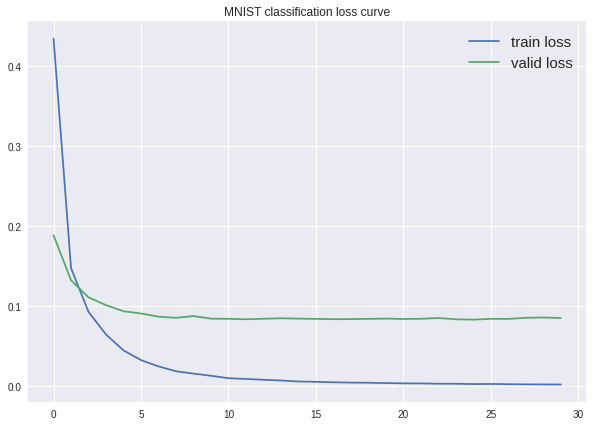

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

ax.plot(loss_train, label='train loss')
ax.plot(loss_valid, label='valid loss')
ax.set_title("MNIST classification loss curve")
ax.legend(fontsize=15)
plt.style.use("seaborn")

plt.show()

보이는 것과 같이, valid loss가 내려올 기미를 보이지 않는다. epoch가 100에 가까워질 수록 valid loss가 조금씩 높아지는 것으로 보아, overfitting의 기미도 보이는 듯 하다.

hyper parameter tuning을 할 필요가 있어 보인다.

# test

In [149]:
import numpy as np

y_pred_list, y_list = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.type(torch.cuda.FloatTensor)     
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x).to(device)
        
        y_pred_list += y_pred
        y_list += y

    y_pred_list = torch.stack(y_pred_list, dim=0)
    y_list = torch.stack(y_list, dim=0)

    accuracy = float((torch.argmax(y_pred_list, dim=-1) == y_list).detach().sum() / len(test_loader))
    
    print("accuracy : %.3f" % accuracy)

accuracy : 85.190


정확도가 그리 높지 않다. hyper parameter tuning, CNN 구조를 통한 spatial feature information extraction 등 다양한 방법을 사용해봐야 겠다.